In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, recall_score
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
import xgboost
from imblearn.ensemble import BalancedBaggingClassifier 
from imblearn.ensemble import BalancedRandomForestClassifier 
import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

In [2]:
df1 = pd.read_csv('ga_hits.csv')

In [3]:
df2 = pd.read_csv('ga_sessions.csv')

In [4]:
df1.shape

(15726470, 11)

In [5]:
df2.shape

(1860042, 18)

In [6]:
df1.isna().sum().sort_values(ascending=False)

event_value       15726470
hit_time           9160322
hit_referer        6274804
event_label        3760184
session_id               0
hit_date                 0
hit_number               0
hit_type                 0
hit_page_path            0
event_category           0
event_action             0
dtype: int64

### Работа с целевой переменной

In [7]:
df1.loc[df1['event_action'].isin(["sub_car_claim_click", "sub_open_dialog_click", "sub_custom_question_submit_click","sub_call_number_click", "sub_callback_submit_click", "sub_submit_success", "sub_car_request_submit_click", "sub_car_claim_submit_click"]) == False, 'event_action'] = 0
df1.loc[df1['event_action'].isin(["sub_car_claim_click", "sub_open_dialog_click", "sub_custom_question_submit_click","sub_call_number_click", "sub_callback_submit_click", "sub_submit_success", "sub_car_request_submit_click", "sub_car_claim_submit_click"]) == True, 'event_action'] = 1

In [8]:
df1["event_action"].value_counts()

0    15621562
1      104908
Name: event_action, dtype: int64

## Объединение датасетов

In [9]:
df1_new = df1.groupby('session_id').agg({'event_action': 'max', 'hit_number': 'max'}).reset_index()

In [10]:
df1_new["hit_number"].value_counts()

3      294712
2      178446
4      166282
8      101211
6       65161
        ...  
357         1
312         1
384         1
457         1
414         1
Name: hit_number, Length: 438, dtype: int64

In [11]:
filtered_df = df1_new[((df1_new["event_action"] == 1) & (df1_new['hit_number'] > 1) & (df1_new['hit_number'] < 50))]

In [12]:
stats_5 = filtered_df.groupby(['hit_number'], as_index=False)[['session_id']].count().sort_values("hit_number", ascending=False)
stats_5 = stats_5.rename(columns={'session_id': 'count'})

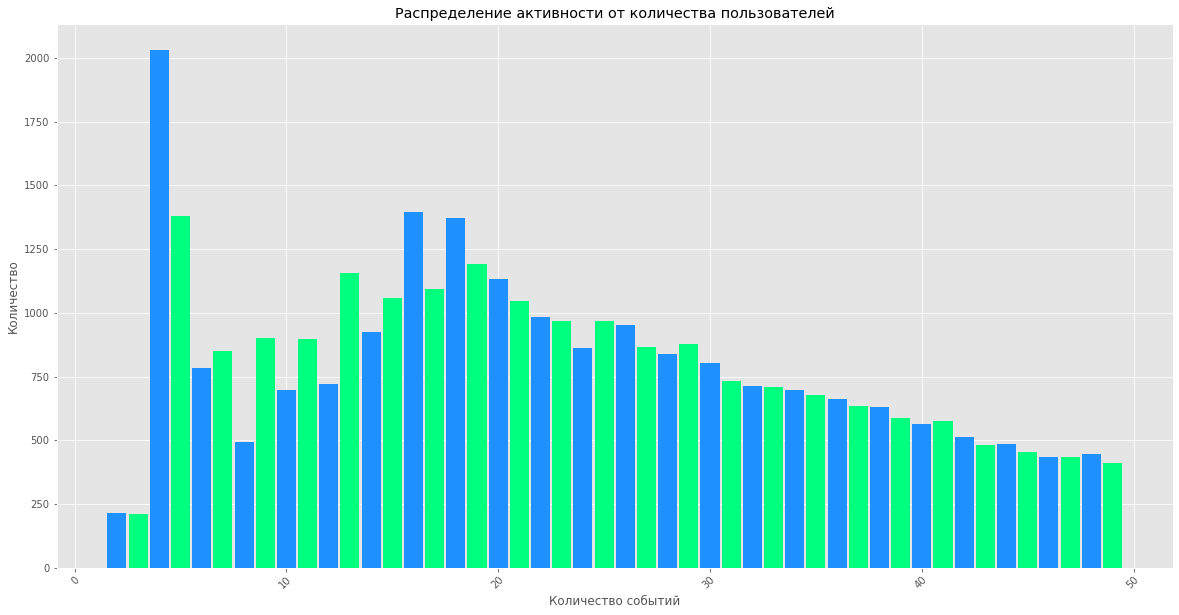

In [18]:
plt.figure(figsize=(20, 10))
plt.bar(stats_5['hit_number'], stats_5['count'], color=['springgreen', 'dodgerblue'], width = 0.9)
plt.xlabel('Количество событий')
plt.xticks(rotation = 45, ha = "right", rotation_mode = "anchor")
plt.ylabel('Количество')
plt.title('Распределение активности от количества пользователей');

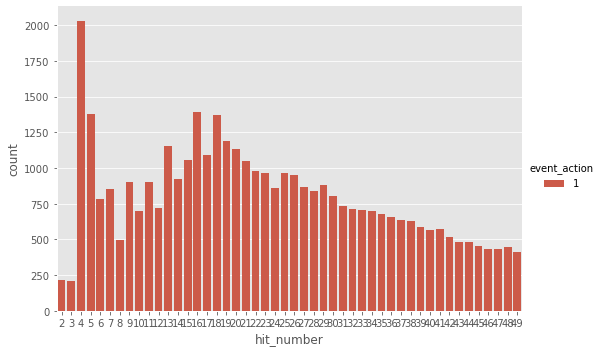

In [13]:
sns.catplot(x='hit_number',
            hue='event_action',
            kind='count',
            data=filtered_df,
            height = 5,
            aspect = 1.5);

In [13]:
filtered_df2 = df1_new[((df1_new['hit_number'] > 1) & (df1_new['hit_number'] < 40))]

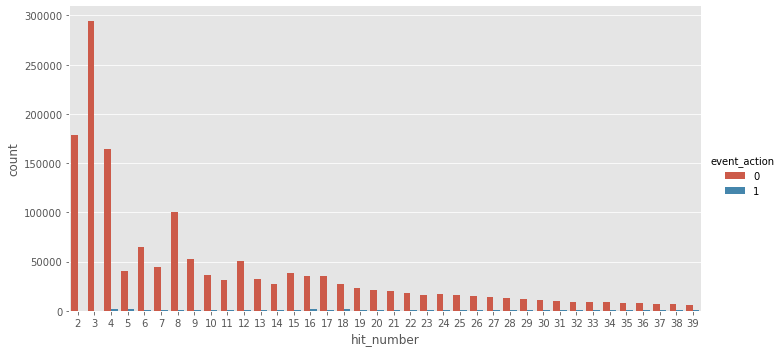

In [14]:
sns.catplot(x='hit_number',
            hue='event_action',
            kind='count',
            data=filtered_df2,
            height = 5,
            aspect = 2);

In [15]:
df1_new['session_id'].duplicated().sum()

0

In [16]:
df_all = df1_new.merge(df2, how = "left")

### Пропуски,обработка данных

In [17]:
def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))

In [18]:
print_useful_rows_info(df_all)

Количество полностью заполненных объектов из всей выборки: 13829
Процент полностью заполненных объектов из всей выборки: 0.8


In [19]:
missing_values = ((df_all.isna().sum() / len(df_all)) * 100).sort_values(ascending=False)
print('Процент пропущенных значений:')
missing_values

Процент пропущенных значений:


device_model                99.131678
utm_keyword                 58.981327
device_os                   58.590000
device_brand                20.150927
utm_adcontent               17.668583
utm_campaign                11.393397
utm_source                   0.139513
geo_country                  0.135131
device_browser               0.135131
device_screen_resolution     0.135131
device_category              0.135131
geo_city                     0.135131
utm_medium                   0.135131
visit_number                 0.135131
visit_time                   0.135131
visit_date                   0.135131
client_id                    0.135131
event_action                 0.000000
hit_number                   0.000000
session_id                   0.000000
dtype: float64

In [20]:
df_all = df_all.drop(['device_model', 'utm_keyword', "utm_adcontent", 'session_id', "visit_time", "client_id", "device_screen_resolution", 'visit_number'], axis=1) 

In [21]:
df_all = df_all[~(df_all.geo_city.isna())]
df_all = df_all[~(df_all.utm_source.isna())]
df_all = df_all.drop(['device_os'], axis=1) 
df_all.device_brand = df_all.device_brand.fillna('other')
df_all = df_all[~(df_all.utm_campaign.isna())]
df_all.isna().sum().sort_values(ascending=False)

event_action       0
hit_number         0
visit_date         0
utm_source         0
utm_medium         0
utm_campaign       0
device_category    0
device_brand       0
device_browser     0
geo_country        0
geo_city           0
dtype: int64

In [22]:
df_all["visit_date"] = pd.to_datetime(df_all.visit_date, utc=True)

In [23]:
df_all['month'] = df_all.visit_date.apply (lambda x: x.month)

In [24]:
df_all = df_all.drop(['visit_date'], axis=1) 
df_all.month = df_all.month.astype(int)

In [25]:
df_all.loc[df_all['utm_medium'].isin(["(none)", "referral", "organic"]) == False, 'utm_medium'] = "cost"
df_all.loc[df_all['utm_medium'].isin(["(none)", "referral", "organic"]) == True, 'utm_medium'] = "organical"

In [26]:
df_all["utm_medium"].value_counts()

cost         1073478
organical     463425
Name: utm_medium, dtype: int64

In [27]:
drop_utm = df_all.utm_campaign.value_counts()[df_all.utm_campaign.value_counts()<10000].index
df_all.utm_campaign[df_all.utm_campaign.isin(drop_utm)] = "rare"

## Создание частотных переменных

In [28]:
fe1 = df_all.groupby("utm_source").size()/len(df_all)
df_all["utm_source_freq"] = df_all["utm_source"].map(fe1)
fe2 = df_all.groupby("utm_medium").size()/len(df_all)
df_all["utm_medium_freq"] = df_all["utm_medium"].map(fe2)
fe3 = df_all.groupby("device_category").size()/len(df_all)
df_all["device_category_freq"] = df_all["device_category"].map(fe3)
fe4 = df_all.groupby("device_brand").size()/len(df_all)
df_all["device_brand_freq"] = df_all["device_brand"].map(fe4)
fe5 = df_all.groupby("device_browser").size()/len(df_all)
df_all["device_browser_freq"] = df_all["device_browser"].map(fe5)
fe8 = df_all.groupby("geo_country").size()/len(df_all)
df_all["geo_country_freq"] = df_all["geo_country"].map(fe8)
fe7 = df_all.groupby("geo_city").size()/len(df_all)
df_all["geo_city_freq"] = df_all["geo_city"].map(fe7)
fe6 = df_all.groupby("utm_campaign").size()/len(df_all)
df_all["utm_campaign_freq"] = df_all["utm_campaign"].map(fe6)

In [29]:
corr_matrix = df_all.corr()
corr_matrix["event_action"].sort_values(ascending=False)

event_action            1.000000
hit_number              0.199655
utm_campaign_freq       0.054173
utm_source_freq         0.010748
geo_city_freq           0.007238
device_brand_freq       0.006871
geo_country_freq        0.005080
device_browser_freq     0.000171
device_category_freq   -0.010776
month                  -0.057792
utm_medium_freq        -0.062120
Name: event_action, dtype: float64

### Стандартизация

In [30]:
std_scaler = StandardScaler()
std_scaler

StandardScaler()

In [31]:
std_scaler.fit(df_all[["utm_campaign_freq", 'device_brand_freq', "utm_source_freq", "device_browser_freq", "device_category_freq", "utm_medium_freq", "month", 'hit_number', "geo_country_freq", "geo_city_freq"]])

StandardScaler()

In [32]:
std_scaled = std_scaler.transform(df_all[["utm_campaign_freq", 'device_brand_freq', "utm_source_freq", "device_browser_freq", "device_category_freq", "utm_medium_freq", "month", 'hit_number', "geo_country_freq", "geo_city_freq"]])

In [33]:
df_all[["utm_campaign_freq", 'device_brand_freq', "utm_source_freq", "device_browser_freq", "device_category_freq", "utm_medium_freq", "month", 'hit_number', "geo_country_freq", "geo_city_freq"]] = std_scaled

### Моделирование

In [34]:
x = df_all.drop(["utm_source", "utm_medium", "device_browser", "geo_country", "geo_city", "event_action", "device_category", "device_brand", "utm_campaign"], axis=1)
y = df_all['event_action']

In [35]:
print(len(x), len(y))

1536903 1536903


In [36]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)

### Логистическая регрессия

AUC: 0.776


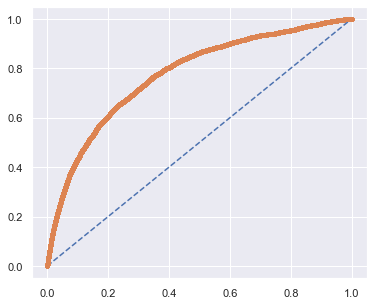

In [104]:
logreg = LogisticRegression()
logreg.fit(train_x, train_y)
probs = logreg.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, probs)
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, probs)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()

### Дерево решений

AUC: 0.586


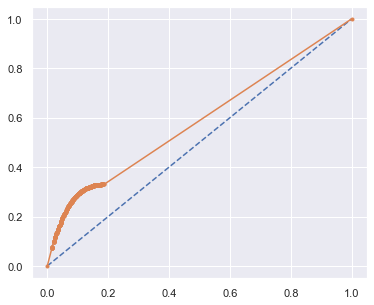

In [105]:
clf = DecisionTreeClassifier()
clf.fit(train_x, train_y)
probs = clf.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, probs)
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, probs)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()

### Нейронные сети

AUC: 0.833


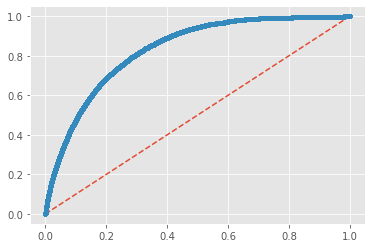

In [118]:
mlp = MLPClassifier(random_state=42, max_iter=500)
mlp.fit(train_x, train_y)
probs = mlp.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, probs)
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, probs)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()

### Случайный лес

AUC: 0.744


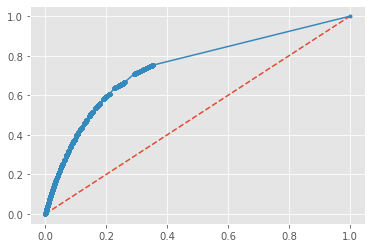

In [119]:
rf_clf = RandomForestClassifier()
rf_clf.fit(train_x, train_y)
probs = rf_clf.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, probs)
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, probs)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()

### Xboost Лучшая модель

AUC: 0.850


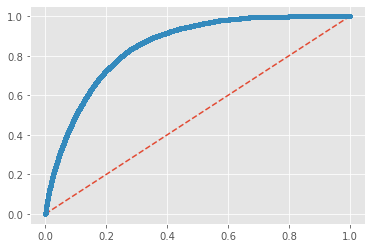

In [59]:
y.value_counts()[0]/y.value_counts()[1]
clf_1 = xgboost.XGBClassifier(objective = "binary:logistic", scale_pos_weight=34.63).fit(train_x,train_y) 
predict_1 = clf_1.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y,predict_1) 
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, predict_1)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()

In [60]:
clf_1.feature_importances_

array([0.50993514, 0.06268198, 0.0802392 , 0.07663925, 0.06010612,
       0.04796989, 0.04372433, 0.01690567, 0.02756398, 0.07423438],
      dtype=float32)

In [61]:
f_imp_list = list(zip(train_x.columns, clf_1.feature_importances_))
f_imp_list.sort(key = lambda x: x[1], reverse=True)

[('hit_number', 0.50993514),
 ('month', 0.06268198),
 ('utm_source_freq', 0.0802392),
 ('utm_medium_freq', 0.07663925),
 ('device_category_freq', 0.060106125),
 ('device_brand_freq', 0.047969885),
 ('device_browser_freq', 0.04372433),
 ('geo_country_freq', 0.016905671),
 ('geo_city_freq', 0.02756398),
 ('utm_campaign_freq', 0.07423438)]

## Тюнинг лучшей модели

In [ ]:
parameters = {
              'max_depth': [5, 10, 15, 20, 25],
              'learning_rate': [0.01, 0.05, 0.1, 0.15],
              'n_estimators': [500, 1000, 2000, 3000, 5000],
              'min_child_weight': [1, 5, 15, 200],
              'subsample': [0.6, 0.8, 0.95],
              'colsample_bytree': [0.5, 0.7, 0.9], 
}
xlf = xgboost.XGBClassifier(objective = "binary:logistic", scale_pos_weight=34.63).fit(train_x, train_y)           
cv = RandomizedSearchCV(estimator = xlf, param_distributions=parameters, n_iter = 60, cv=3, n_jobs = -1)
cv.fit(train_x, train_y)    
print(cv.best_params_)

In [ ]:
clf_best = xgboost.XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=2000, 
            objective='binary:logistic',
            min_child_weight=1,
            subsample=0.85,
            colsample_bytree=0.7,
            scale_pos_weight=34.63,).fit(train_x,train_y) 
predict_10 = clf_best.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y,predict_10) 
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, predict_10)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()

### Catboost

In [37]:
params = {'depth': [4, 7, 10],
          'learning_rate': [0.03, 0.1, 0.15],
          'l2_leaf_reg': [1, 4, 9],
          'iterations': [300, 500]}
label_ratio = (y==1).sum()/(y==0).sum()
cb = cb.CatBoostClassifier(scale_pos_weight = label_ratio, logging_level='Silent')
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv=3)
cb_model.fit(train_x, train_y)
print(cb_model.best_score_) 
print(cb_model.best_params_)  

0:	total: 528ms	remaining: 4m 23s
1:	total: 1.01s	remaining: 4m 12s
2:	total: 1.53s	remaining: 4m 12s
3:	total: 2.04s	remaining: 4m 12s
4:	total: 2.43s	remaining: 4m
5:	total: 2.97s	remaining: 4m 4s
6:	total: 3.46s	remaining: 4m 3s
7:	total: 4.01s	remaining: 4m 6s
8:	total: 4.32s	remaining: 3m 55s
9:	total: 4.83s	remaining: 3m 56s
10:	total: 5.27s	remaining: 3m 54s
11:	total: 5.77s	remaining: 3m 54s
12:	total: 6.09s	remaining: 3m 48s
13:	total: 6.53s	remaining: 3m 46s
14:	total: 6.93s	remaining: 3m 44s
15:	total: 7.43s	remaining: 3m 44s
16:	total: 7.88s	remaining: 3m 43s
17:	total: 8.35s	remaining: 3m 43s
18:	total: 8.76s	remaining: 3m 41s
19:	total: 9.14s	remaining: 3m 39s
20:	total: 9.56s	remaining: 3m 38s
21:	total: 9.93s	remaining: 3m 35s
22:	total: 10.3s	remaining: 3m 34s
23:	total: 10.7s	remaining: 3m 32s
24:	total: 11.1s	remaining: 3m 30s
25:	total: 11.5s	remaining: 3m 29s
26:	total: 11.9s	remaining: 3m 27s
27:	total: 12.2s	remaining: 3m 26s
28:	total: 12.6s	remaining: 3m 25s
29

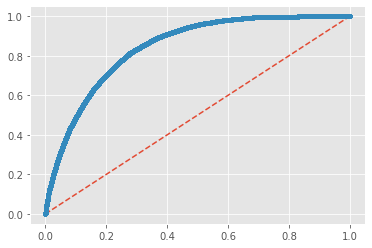

In [57]:
label_ratio = (y==1).sum()/(y==0).sum()
clf_cb_best = cb.CatBoostClassifier(eval_metric="AUC", depth=10, iterations=500, l2_leaf_reg=1,
                            learning_rate=0.15, scale_pos_weight = label_ratio)

clf_cb_best.fit(train_x, train_y)
predict_be = clf_cb_best.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y,predict_be) 
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, predict_be)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()

### BalancedBaggingClassifier

AUC: 0.719


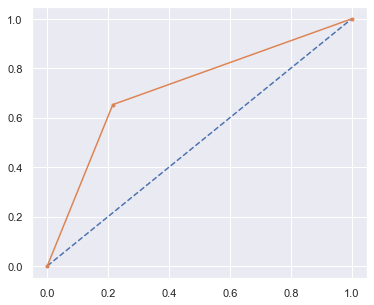

In [108]:
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
bbc.fit(train_x, train_y)
preds = bbc.predict(test_x)
auc = roc_auc_score(test_y, preds)
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, preds)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()

AUC: 0.764


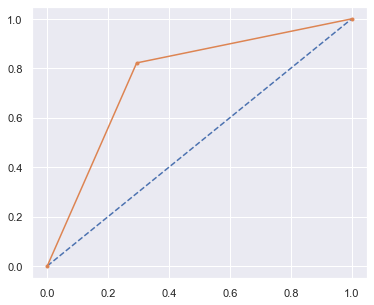

In [109]:
blc = BalancedRandomForestClassifier()
blc.fit(train_x, train_y)
preds = blc.predict(test_x)
auc = roc_auc_score(test_y, preds)
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, preds)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()

## SMOTE MLP

AUC: 0.843


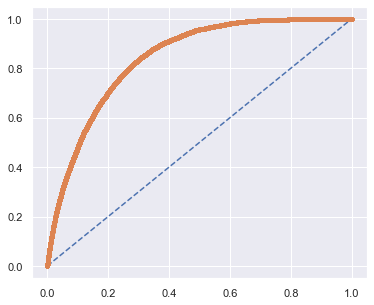

In [115]:
sm = SMOTE(random_state=42, k_neighbors=5)
X_res, y_res = sm.fit_resample(x, y)
x_train, x_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
mlp = MLPClassifier(random_state=42, max_iter=500)
mlp.fit(x_train, y_train)
probs = mlp.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, probs)
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, probs)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()

## SMOTE xgboost

AUC: 0.822


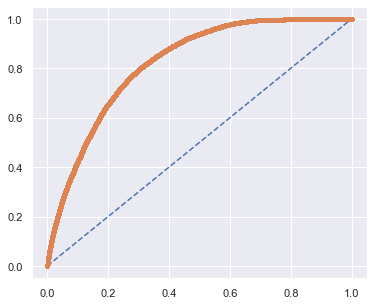

In [116]:
sm = SMOTE(random_state=42, k_neighbors=5)
X_res, y_res = sm.fit_resample(x, y)
x_train, x_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
clf_1 = xgboost.XGBClassifier(objective = "binary:logistic", scale_pos_weight=34.63).fit(x_train,y_train) 
probs = clf_1.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, probs)
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, probs)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()

## Nearmiss MLP

AUC: 0.597


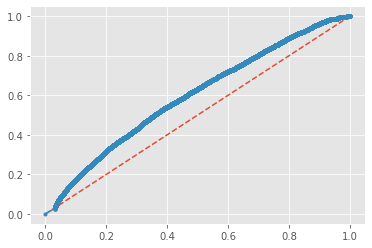

In [124]:
nm = NearMiss()
x_train_miss, y_train_miss = nm.fit_resample(train_x, train_y)
mlp = MLPClassifier(random_state=42, max_iter=500)
mlp.fit(x_train_miss, y_train_miss)
probs = mlp.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, probs)
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, probs)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()

## Nearmiss xgboost

AUC: 0.527


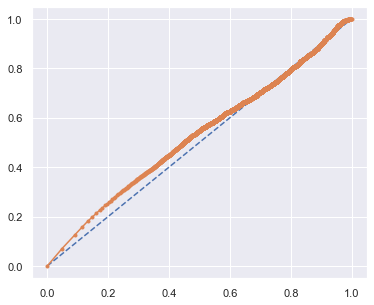

In [114]:
nm = NearMiss()
x_train_miss, y_train_miss = nm.fit_resample(train_x, train_y)
clf_1 = xgboost.XGBClassifier(objective = "binary:logistic", scale_pos_weight=34.63).fit(x_train_miss, y_train_miss) 
probs = clf_1.predict_proba(test_x)[:, 1]
probs = clf_1.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, probs)
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, probs)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()

### Метод опорных векторов

In [ ]:
clf_proba = SVC(kernel = "linear", class_weight = {1: 33}).fit(train_x, train_y)
auc = roc_auc_score(test_y, clf_proba.decision_function(test_x)[:, 1])
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, probs)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()

### Метод ближайших соседей

In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(train_x, train_y)
probs = KNN_model.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, probs)
print("AUC: %.3f" % auc)
fpr, tpr, thresholds = roc_curve(test_y, probs)
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(fpr, tpr, marker = ".")
plt.show()